In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Activation, Dropout
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import mean_squared_error

# Load Data

In [3]:
df_power = pd.read_csv("./data/power_usage_2016_to_2020.csv")
df_weather = pd.read_csv("./data/weather_2016_2020_daily.csv")

# Wrangle Data

In [4]:
def wrangle(df_power, df_weather):
    
    # Convert Dates to DateTime objects
    df_power["StartDate"] = pd.to_datetime(df_power.StartDate)
    df_weather["Date"] = pd.to_datetime(df_weather.Date)
    
    # Set Datetime columns to index
    df_power.index = df_power["StartDate"]
    df_weather.index = df_weather["Date"]
    
    # Drop unecessary columns
    drop_weather = ['Date']
    df_weather.drop(columns=drop_weather, inplace=True)
    
    drop_power = ["StartDate", "day_of_week"]
    df_power.drop(columns=drop_power, inplace=True)
    
    # Clean up column names
    rename_power = {"Value (kWh)": "kWh", "notes": "type_of_day"}
    df_power.rename(columns=rename_power, inplace=True)
    
    # Resample df_power to "D" (Day) granularity
    df_power = df_power.resample("D").sum()
    
    # Merge df_power, df_weather
    df = df_power.merge(df_weather, left_index=True, right_index=True)
    
    return df

In [5]:
df = wrangle(df_power, df_weather)
df.head()

,kWh,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
2016-01-06,29.691,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
2016-01-07,43.177,1,94,84.9,76,76,74.0,72,94,71.6,51,13,5.7,0,29.9,29.9,29.8,0.00,3
2016-01-08,50.057,1,97,86.5,75,76,73.3,67,96,67.3,37,20,6.0,0,30.0,29.9,29.9,0.00,4
2016-01-09,47.363,1,96,86.2,78,75,73.3,70,88,67.1,46,13,6.3,0,29.8,29.8,29.7,0.01,5
2016-01-10,42.203,1,81,71.1,61,64,59.4,57,90,68.7,45,8,3.3,0,30.0,29.9,29.9,0.00,6


# EDA Visualizations

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

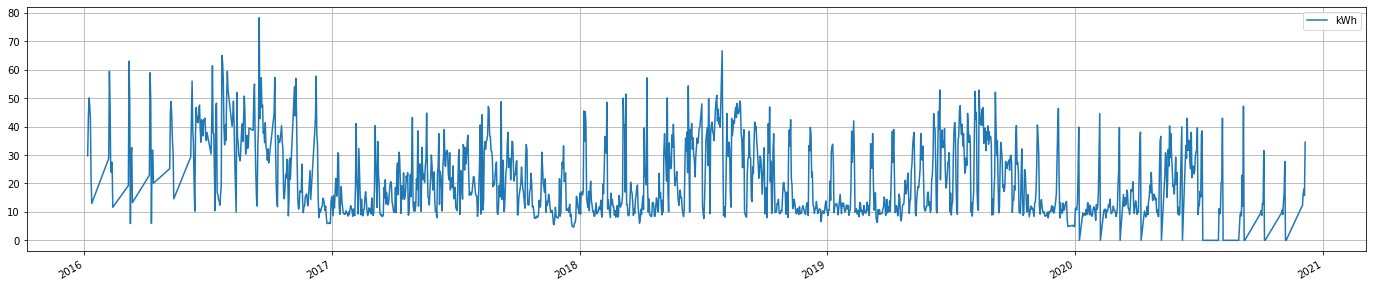

In [6]:
df.kWh.plot(figsize=(24,5), grid=True, legend=True)
plt.xlabel

<AxesSubplot:>

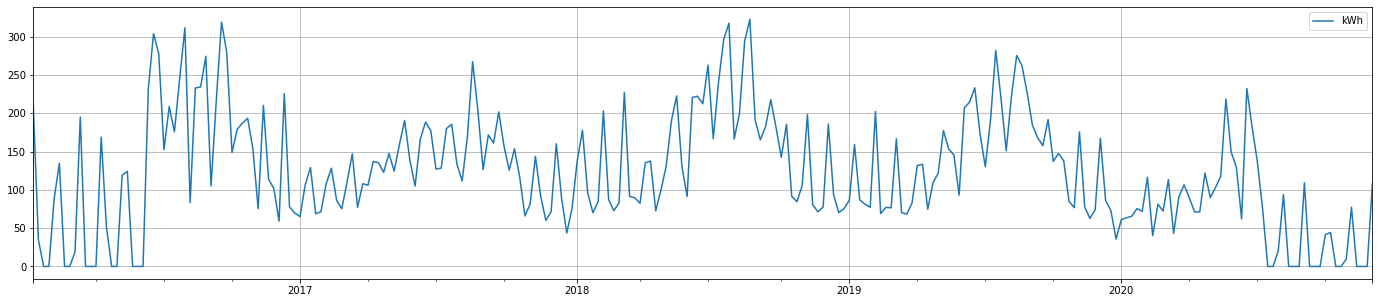

In [7]:
df["kWh"].resample("W").sum().plot(figsize=(24, 5), grid=True, legend=True)

<AxesSubplot:>

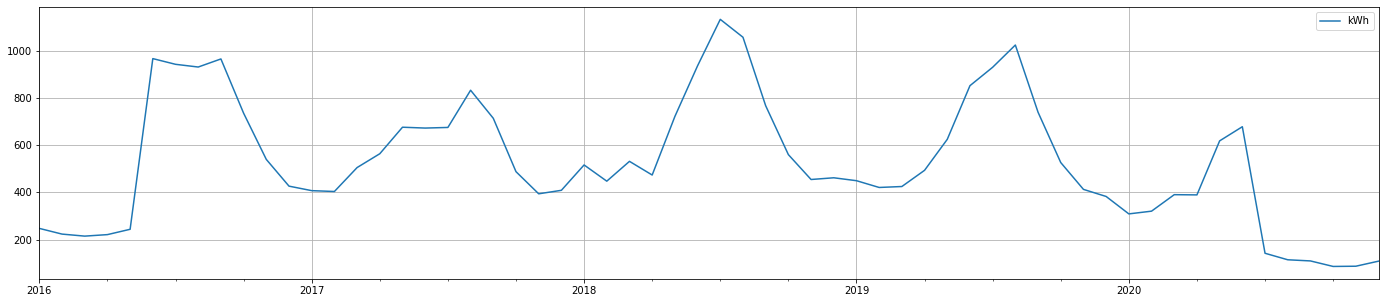

In [8]:
df["kWh"].resample("M").sum().plot(figsize=(24,5), grid=True, legend=True)

<AxesSubplot:>

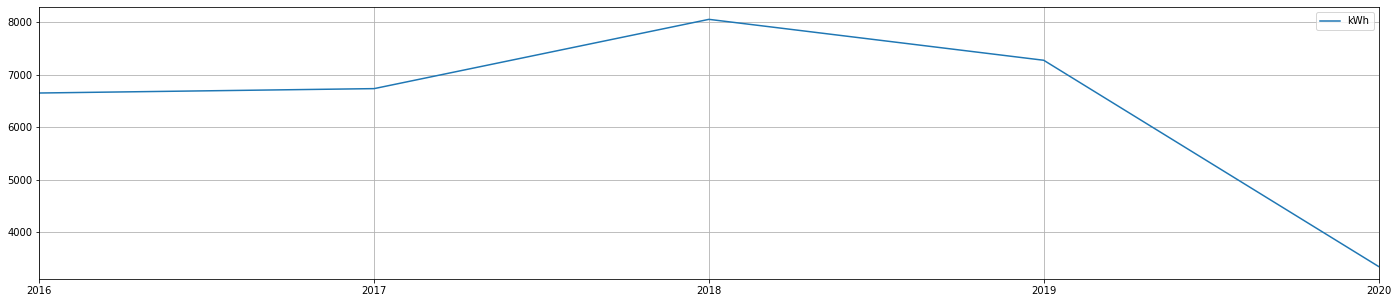

In [9]:
df["kWh"].resample("A").sum().plot(figsize=(24,5), grid=True, legend=True)

# Correlation Heat Map

<AxesSubplot:>

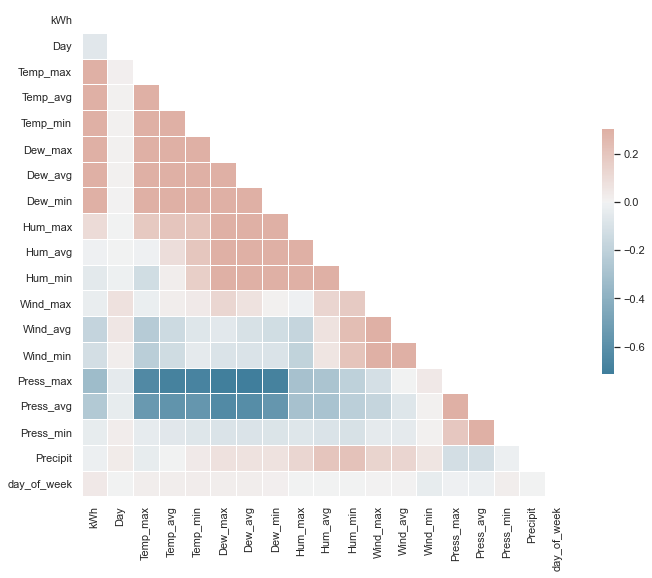

In [10]:
import seaborn as sns
from string import ascii_letters

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Keep correlating columns above a certain theshold

In [11]:
def keep_corr_values(df, mask=0.10):
    corr_mask = df.corr()["kWh"].abs() > mask
    keep_feats = df.corr()["kWh"][corr_mask].index
    df = df[keep_feats]
    return df

In [12]:
df = keep_corr_values(df)
df.head()

,kWh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Wind_avg,Wind_min,Press_max,Press_avg
2016-01-06,29.691,85,74.8,68,74,71.4,66,100,9.5,0,29.8,29.8
2016-01-07,43.177,94,84.9,76,76,74.0,72,94,5.7,0,29.9,29.9
2016-01-08,50.057,97,86.5,75,76,73.3,67,96,6.0,0,30.0,29.9
2016-01-09,47.363,96,86.2,78,75,73.3,70,88,6.3,0,29.8,29.8
2016-01-10,42.203,81,71.1,61,64,59.4,57,90,3.3,0,30.0,29.9


In [13]:
df.shape

(1550, 12)

# Split Data

In [ ]:
# tscv = TimeSeriesSplit(test_size=)

In [14]:
def scale_data(df):
    """
    Scale time series features, save the scaler function for each feature in a look up dict for inverse scaling post model training. 
    
    Parameters
    ----------
    df: pandas dataframe
    
    Returns
    -------
    df: pandas datafarme 
        Contains scaled features
        
    scaler_dict: dict 
        look up for feature scaler objects 
        key: column name
        value: column scaler 
    """
    
    # use to save the column scaler functions
    scaler_dict = {} 
    
    # use to save the scaled column data
    scaled_data = {} 
    
    for col in df.columns:
        
        # instantiate the scaler class 
        scaler = MinMaxScaler(feature_range=(0, 1))
        
        # reshape to avoid shape errors
        feat = df[col].values.reshape(-1, 1)
        
        # scale data
        # DATA LEAKAGE! scaler should only be fitted on the training data
        # train test split should have occured prior to scaling 
        col_scaled = scaler.fit_transform(feat)
        
        # save scaled column data to column key
        scaled_data[col] = col_scaled.flatten()
        
        # save scaler function to column key 
        scaler_dict[col] = scaler
        
    # move scaled data from dict to dataframe
    df_scaled = pd.DataFrame.from_dict(scaled_data)
    
    return df_scaled, scaler_dict

In [15]:
df_scaled, scaler_dict = scale_data(df)

In [16]:
df_scaled.head()

,kWh,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Wind_avg,Wind_min,Press_max,Press_avg
0,0.379558,0.761194,0.756410,0.819277,0.861538,0.873874,0.846154,1.00,0.354260,0.0,0.272727,0.555556
1,0.551957,0.895522,0.918269,0.915663,0.892308,0.912913,0.923077,0.88,0.183857,0.0,0.363636,0.611111
2,0.639908,0.940299,0.943910,0.903614,0.892308,0.902402,0.858974,0.92,0.197309,0.0,0.454545,0.611111
3,0.605469,0.925373,0.939103,0.939759,0.876923,0.902402,0.897436,0.76,0.210762,0.0,0.272727,0.555556
4,0.539506,0.701493,0.697115,0.734940,0.707692,0.693694,0.730769,0.80,0.076233,0.0,0.454545,0.611111


<AxesSubplot:>

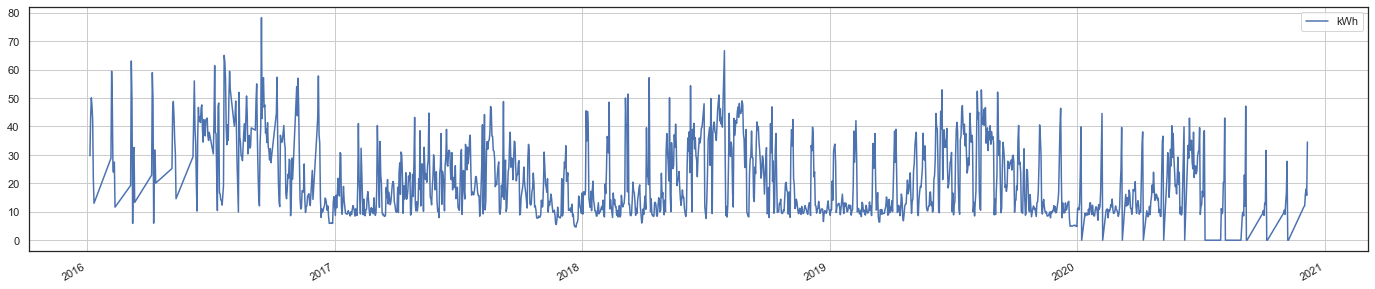

In [17]:
df["kWh"].plot(figsize=(24, 5), grid=True, legend=True)

<AxesSubplot:>

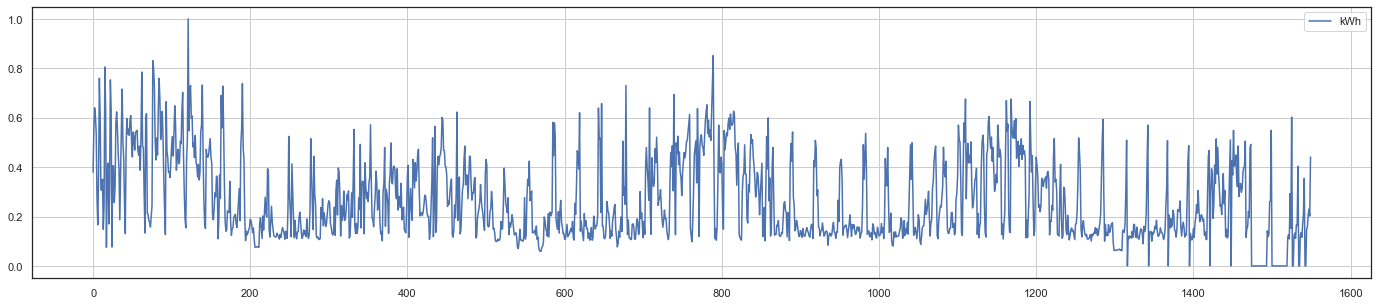

In [18]:
df_scaled["kWh"].plot(figsize=(24, 5), grid=True, legend=True)

In [19]:
scaler_dict["kWh"]

MinMaxScaler()

In [47]:
df_scaled.shape

(1550, 12)

# Split data into X and Y sets

In [48]:
def create_dataset(data, look_back=1, look_ahead=1):
    # use to store new sequence samples 
    X_data, Y_data = [], []
    
    # number of original samples in dataset
    n_samples = len(data)
    
    # avoid an index error in the for loop by capping the max index value 
    # since we are using look_back & look_ahead number of samples for input and output sequences, respectively
    truncate = look_back + look_ahead 
    
    # number of new samples to create
    # we must subtract truncate from the number of new samples because the size of the look_back & look_ahead windows 
    n_new_samples = n_samples - (truncate + 1)
    
    # if user provided data with more than a single input feature
    # then index for the feature in the 0 index and use that as the output feature
    if data.shape[1] > 1:
        y_data = data[:, 0]
        
    # if user provided a single feature dataset, leave data set as is 
    else:
        y_data = data
        
    # LOGIC FOR CREATING X AND Y 
    # we are going to create n_new_samples number of samples for our model 
    for i in range(n_new_samples):
        
        # create input sequence sample 
        x = data[i : i+look_back]
        
        # create output sequence sample 
        y = y_data[i+look_back : i + look_back + look_ahead ]
        y = y[-1] # y is actually a sequnce, so we need to take the last value as our output (i.e. we are predicting a single value, not multiple)
        
        # append new samples to lists
        X_data.append(x)
        Y_data.append(y)
        
    return np.array(X_data), np.array(Y_data)

# Train Test Split

In [49]:
def create_train_test_split(df, look_back = 1, look_ahead = 1, train_size = 0.60):
    """
    Creates a train test split for sequential data used for time series forecasting. 
    """
    
    # calculate the number of training samples 
    n_samples = df.shape[0]
    train_size = int(n_samples * train_size)

    # samples between the zero and train_size indices are training samples 
    train = df.iloc[:train_size].values
    
    # samples between the train_size and the nth index are test samples 
    test = df.iloc[train_size:].values

    # create input and output splits 
    X_train, Y_train = create_dataset(train, look_back=look_back, look_ahead=look_ahead)
    X_test, Y_test = create_dataset(test, look_back=look_back, look_ahead=look_ahead)
    
    return X_train, Y_train, X_test, Y_test

In [50]:
# split data into X and Y train/test sets 
look_back = 7
look_ahead = 1

X_train, Y_train, X_test, Y_test = create_train_test_split(df, 
                                                            look_back = look_back, 
                                                            look_ahead = look_ahead, 
                                                            train_size = 0.60)

In [51]:
X_train.shape, Y_train.shape

((921, 7, 12), (921,))

In [52]:
X_test.shape, Y_test.shape

((611, 7, 12), (611,))

# Create and train model

In [57]:
n_feats = len(df.columns)
epochs = 20
batch_size = 32
dropout_prob = 0.2

input_shape = (look_back, n_feats)

def build_model():
    n_feats = len(df.columns)
    epochs = 20
    batch_size = 32
    dropout_prob = 0.2

    # (number of timesteps, number of features)
    input_shape = (look_back, n_feats)

    #### Create and train model here

    # Create Sequential instance
    model = Sequential()

    # Add Bidirectional LSTM
    model.add(Bidirectional(LSTM(250, 
                                 input_shape=input_shape,
                                 activation="relu")))

    # Add dropout regularization
    model.add(Dropout(dropout_prob))

    # Add Dense Hidden Layer
    model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.L2(l2=0.001)))

    # Add Dense Output Layer
    model.add(Dense(1, activation="relu"))

    # Compile computational graph - under the hood
    model.compile(loss="mean_squared_error", optimizer="nadam", metrics=["mean_squared_error", "mean_absolute_error"])
    
    return model

In [58]:
model = build_model()

## TensorBoard Model

In [53]:
from tensorboard.plugins.hparams import api as hp

In [65]:
hp = HyperParameters()
hp.Int("units", min_value=50, max_value=250, step=50)
hp.Choice("activation", values=["relu", "softmax"])
hp.Choice("learning_rate", values=[0.1, 0.01, 0.001])


NameError: name 'HyperParameters' is not defined

In [64]:
### TENSORBOARD
n_feats = len(df.columns)
epochs = 20
batch_size = 32
dropout_prob = 0.2

input_shape = (look_back, n_feats)

def build_model2():
    n_feats = len(df.columns)
    epochs = 20
    batch_size = 32
    dropout_prob = 0.2

    # (number of timesteps, number of features)
    input_shape = (look_back, n_feats)

    #### Create and train model here

    # Create Sequential instance
    model = Sequential()

    # Add Bidirectional LSTM
    model.add(Bidirectional(LSTM(units=hp.get("units"), 
                                 input_shape=input_shape,
                                 activation=hp.get("activation"))))

    # Add dropout regularization
    model.add(Dropout(dropout_prob))

    # Add Dense Hidden Layer
    model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.L2(l2=0.001)))

    # Add Dense Output Layer
    model.add(Dense(1, activation="relu"))

    # Compile computational graph - under the hood
    model.compile(loss="mean_squared_error", 
                  optimizer=optimizers.Adam(hp.get("learning_rate"), 
                  metrics=["mean_squared_error", "mean_absolute_error"])
                  
    return model

SyntaxError: unexpected EOF while parsing (588410002.py, line 42)

In [59]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_test, Y_test))

2021-08-08 09:10:27.034219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
29/29 [==============================] - 36s 65ms/step - loss: 373.4479 - mean_squared_error: 373.3634 - mean_absolute_error: 13.7911 - val_loss: 140.2781 - val_mean_squared_error: 140.2102 - val_mean_absolute_error: 9.1727
Epoch 2/20
29/29 [==============================] - 0s 15ms/step - loss: 124.3427 - mean_squared_error: 124.2784 - mean_absolute_error: 8.5149 - val_loss: 88.6237 - val_mean_squared_error: 88.5677 - val_mean_absolute_error: 6.6906
Epoch 3/20
29/29 [==============================] - 0s 15ms/step - loss: 106.1454 - mean_squared_error: 106.0911 - mean_absolute_error: 7.6905 - val_loss: 88.8560 - val_mean_squared_error: 88.8055 - val_mean_absolute_error: 6.7372
Epoch 4/20
29/29 [==============================] - 0s 15ms/step - loss: 112.5150 - mean_squared_error: 112.4652 - mean_absolute_error: 7.9413 - val_loss: 91.8792 - val_mean_squared_error: 91.8311 - val_mean_absolute_error: 6.9117
Epoch 5/20
29/29 [==============================] - 0s 15ms/step - loss:

In [26]:
def plot_model_loss_metrics(history):
    """
    Use the model history callback to plot the train and test losses vs epochs as well as metrics vs. epochs 
    """
    
    # plot training and test loss scores
    # HARD CODING IS A NO-NO
    # better written code would have the flexibility to plot whatever metrics the user provides 
    test_loss = history.history["val_loss"]
    train_loss = history.history["loss"]
    
    test_mse = history.history["val_mean_squared_error"]
    train_mse = history.history["mean_squared_error"]
    
    test_mae = history.history["val_mean_absolute_error"]
    train_mae = history.history["mean_absolute_error"]
    
    n_epochs = len(test_loss) + 1
    epoches = np.arange(1,  n_epochs)
    y_ticks = np.arange(0, 1, 11)

    plt.figure(figsize=(20,5))
    plt.title("Loss vs. Number of Epochs")
    plt.plot(epoches, test_loss, label = "Test Loss")
    plt.plot(epoches, train_loss, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_squared_error vs. Number of Epochs")
    plt.plot(epoches, test_mse, label = "Test Loss")
    plt.plot(epoches, train_mse, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(20,5))
    plt.title("mean_absolute_error vs. Number of Epochs")
    plt.plot(epoches, test_mae, label = "Test Loss")
    plt.plot(epoches, train_mae, label = "Train Loss")
    plt.xlim(1,20)
    plt.xticks(epoches)
    plt.grid()
    plt.legend()
    plt.show() 

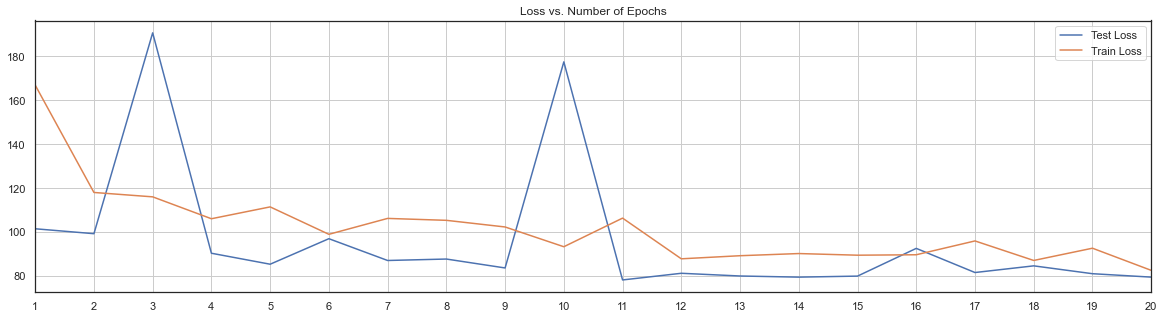

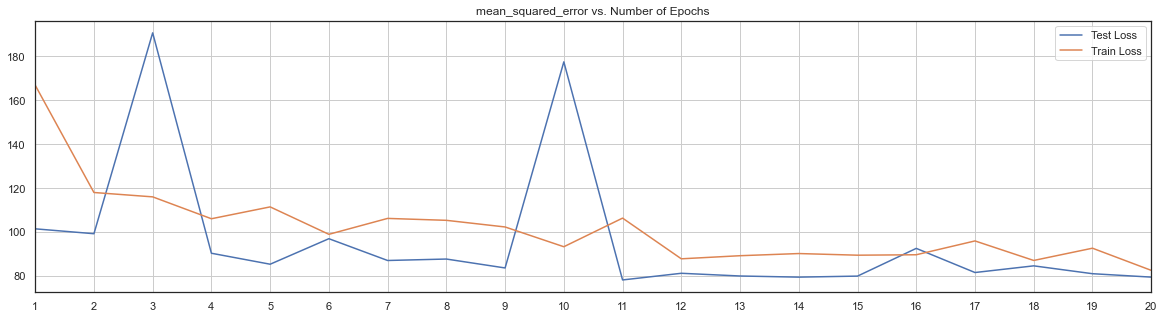

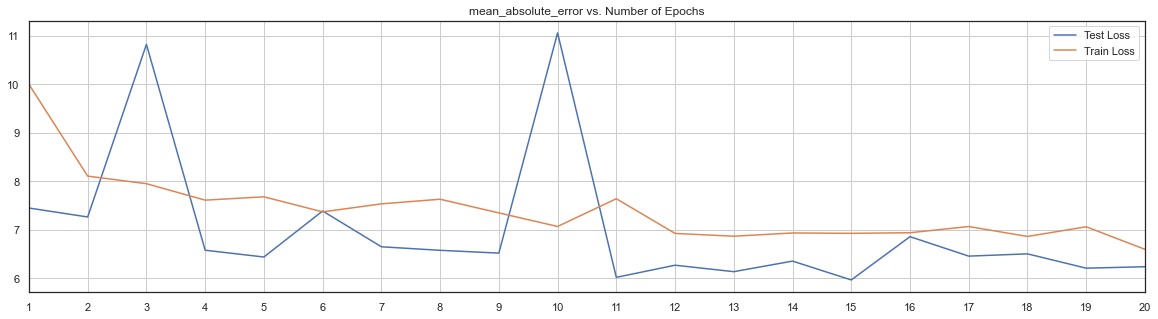

In [27]:
# plot model scores
plot_model_loss_metrics(history)

In [28]:
def predict(X_train, X_test):
    # make predictions on train and test inputs 
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    
    return y_train_predict, y_test_predict

In [29]:
# get predictions 
y_train_predict, y_test_predict = predict(X_train, X_test)

In [30]:
# Y_test and Y_train can be passed through this function only once
# predictions can be passed in here multiple times 
def inverse_scaling(data, scaler_dict, output_feat_name):
    """
    Now that we have trained our model on scaled data (and made predictions on the scaled test data)
    we need to invert the scaling so we have have the data in it's original formate for interpretability. 
    """
    return scaler_dict[output_feat_name].inverse_transform(data)

In [31]:
# reshape Y_train and Y_test so number of rows appers first, i.e. (rows,cols)
Y_train = Y_train.reshape((Y_train.shape[0], 1))
Y_test = Y_test.reshape((Y_test.shape[0], 1))

# perform inverse scaling of the Y train and test sets
Y_train = inverse_scaling(Y_train, scaler_dict, "kWh")
Y_test = inverse_scaling(Y_test, scaler_dict, "kWh")

In [32]:
# perform inverse scaling of the model predictions 
Y_train = inverse_scaling(Y_train, scaler_dict, "kWh")
Y_test = inverse_scaling(Y_test, scaler_dict, "kWh")

In [37]:
def plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict):
    
    
    plt.figure(figsize=(20,5))
    plt.title("Training Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_train_predict, label = "Predict", c="r")
    plt.plot(Y_train, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();
    
    plt.figure(figsize=(20,5))
    plt.title("Test Set: True vs Predicted kWh")
    plt.grid()
    plt.plot(y_test_predict, label = "Predict", c="r")
    plt.plot(Y_test, label= "True", c="c")
    plt.xlim((0,300))
    plt.legend();

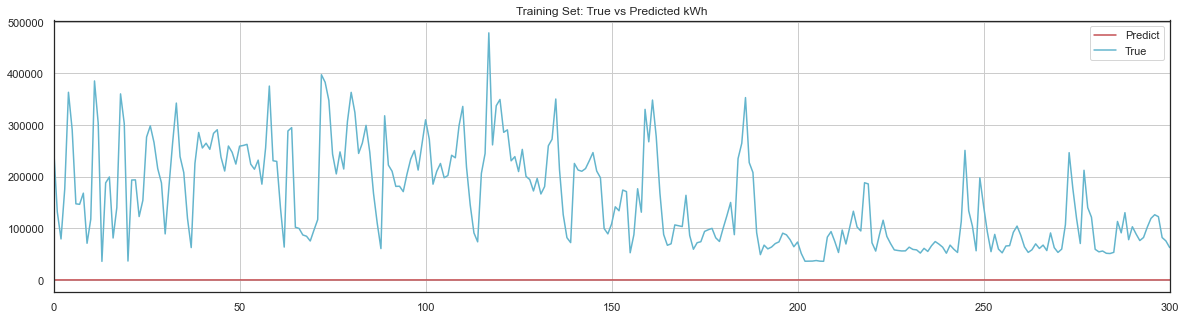

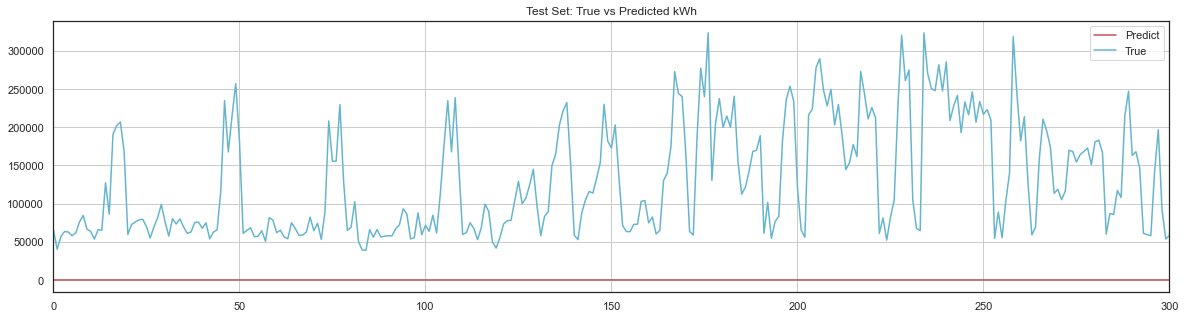

In [38]:
# plot model predictions 
plot_predictions(Y_train, y_train_predict, Y_test, y_test_predict)

In [39]:
# use root mean squared error as metric for comparison 
train_score = math.sqrt(mean_squared_error(Y_train, y_train_predict))
print('Train Score: %.4f RMSE' % (train_score))

test_score = math.sqrt(mean_squared_error(Y_test, y_test_predict))
print('Test Score: %.4f RMSE' % (test_score))

navie_score = math.sqrt(mean_squared_error(...?, ...?))
print('Naive baseline Score: %.4f RMSE' % (test_score))

SyntaxError: invalid syntax (4182203179.py, line 8)